# NP

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from neuralprophet import NeuralProphet, set_log_level, save, load, set_random_seed
from config import *
import pickle
import torch
import contextlib

In [39]:
set_log_level("ERROR")
set_random_seed(111)

## 1. Electricity dataset

In [2]:
csv_file = CONFIG_DICT["datasets"]["electricity"] / "LD2011_2014.csv"
electricity = pd.read_csv(csv_file, index_col=0)

electricity['date'] =  pd.to_datetime(electricity['date'], format='%Y-%m-%d %H:%M:%S.%f')
electricity.rename(columns={"power_usage": "y", "date": "ds", "id": "ID"}, inplace = True)

test_boundary=1339
index = electricity['days_from_start']

train = electricity.loc[(index >= 1250) & (index < test_boundary)]
test = electricity.loc[index >= test_boundary]

## Model

In [3]:
# specify input variables
input_columns = ["ID", "y","ds"]                                  # index + target + datetime

future_regressors = []
lagged_regressors = ['hour', 'day', 'day_of_week', 'month'] 
events = [] 

train = train[input_columns + lagged_regressors]    # with regressors
test = test[input_columns + lagged_regressors] 

In [42]:
m = NeuralProphet(
        growth = "off",                    # no trend
        trend_global_local = "global",
        season_global_local = "global",                
        n_lags = 7*24,                      # autoregressor on last 24h x 7 days
        n_forecasts = 24,                   # forecast horizon
        yearly_seasonality = True,
        weekly_seasonality = True,
        daily_seasonality = True,
        learning_rate = 0.05,
        loss_func = "MSE",
        quantiles = [0.1, 0.5, 0.9]  ,
    )
    
m = m.highlight_nth_step_ahead_of_each_forecast(step_number = m.n_forecasts)
m = m.add_lagged_regressor(names = lagged_regressors)   # , only_last_value=True)

In [44]:
def split_train_test(df, model, num_id=0, valid_p=0.2):
    '''
    to ran only on part of data (for first # id) :   specify parameter num_id, e.g. num_id=5 (for first 5 ids)
    '''
    if num_id==0:
        df = df
    else:
        df = df[df.ID.isin(df.ID.unique()[:num_id])]
    
    df_train, df_test = model.split_df( 
        df,    
        freq='H',
        valid_p = valid_p,         
        local_split = True
    )
    
    return df_train, df_test

df_train, df_val = split_train_test(train, m, num_id=1)

In [21]:
def fit_model(m, df_train, df_val, num_epochs, batch_size, learning_rate, num_workers):
    start_time = time.perf_counter()

    metrics = m.fit(
        df = df_train, 
        validation_df = df_val,
        freq='H', 
        progress="print",
        num_workers = num_workers,
        #early_stopping=True,
        learning_rate=learning_rate,
        epochs=num_epochs,
        batch_size=batch_size
    )                                            
    end_time = time.perf_counter()
    total_time = end_time - start_time
    print(f'Training Took {total_time:.4f} seconds')
    
    return metrics, m   


metrics, model = fit_model(m, df_train=df_train, df_val=df_val, num_epochs=1, batch_size=64, learning_rate=0.05, num_workers=8)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training Took 63.5211 seconds


In [4]:
model_path = CONFIG_DICT["models"]["electricity"] / "neuralprophet" / "np_model.np"

#save(model, model_path)


model = load(model_path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Benedikt\\Desktop\\Mein_Ordner\\WI-INFO\\Semester_4\\Information_Systems\\TFT_project\\RT1_TFT\\models\\electricity\\neuralprophet\\np_model.np'

In [22]:
metrics

MAE_val   RMSE_val   Loss_val  RegLoss_val  epoch        MAE       RMSE  \
0  17.131256  21.766573  14.293156          0.0      0  22.340471  27.995377   

        Loss  RegLoss  
0  12.731114      0.0

In [46]:
# evaluate the test metrics considering time series from all id
model.test(df_val)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    14.293155670166016     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Loss_test  RegLoss_test
0  14.293156           0.0

In [33]:
test2 = test.copy()

In [ ]:
%%capture
predictions = model.predict(test2)

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

Predicting: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\Benedikt\anaconda_main\lib\site-packages\neuralprophet\forecaster.py:3108: PerformanceWarning: D

In [47]:
#test[test["ID"] == "MT_004"]
test.describe()

y          hour           day   day_of_week    month
count   61992.000000  61992.000000  61992.000000  61992.000000  61992.0
mean      759.119582     11.500000      4.000000      3.000000      9.0
std      5154.342093      6.922242      2.000016      2.000016      0.0
min         0.000000      0.000000      1.000000      0.000000      9.0
25%        54.193119      5.750000      2.000000      1.000000      9.0
50%       129.991427     11.500000      4.000000      3.000000      9.0
75%       344.014310     17.250000      6.000000      5.000000      9.0
max    133800.000000     23.000000      7.000000      6.000000      9.0

In [46]:
df_train.describe()

y          hour           day   day_of_week         month
count  13827.000000  13827.000000  13827.000000  13827.000000  13827.000000
mean      10.201648     11.497505     15.281406      2.989369      3.834020
std       11.827090      6.923758      8.613450      2.012859      1.863839
min        0.000000      0.000000      1.000000      0.000000      1.000000
25%        1.737619      5.000000      8.000000      1.000000      2.000000
50%        1.903553     11.000000     15.000000      3.000000      4.000000
75%       22.759602     17.000000     23.000000      5.000000      5.000000
max       45.874822     23.000000     31.000000      6.000000      7.000000

In [40]:
# create a future data frame consisting of the time steps into the future that we need to forecast
future = m.make_future_dataframe(
    test,                          
    n_historic_predictions = True
)

In [41]:
forecast = m.predict(future)

ValueError: Dataset name 'MT_004' missing from training data params. Set unknown_data_normalization to use global (average) normalization parameters.

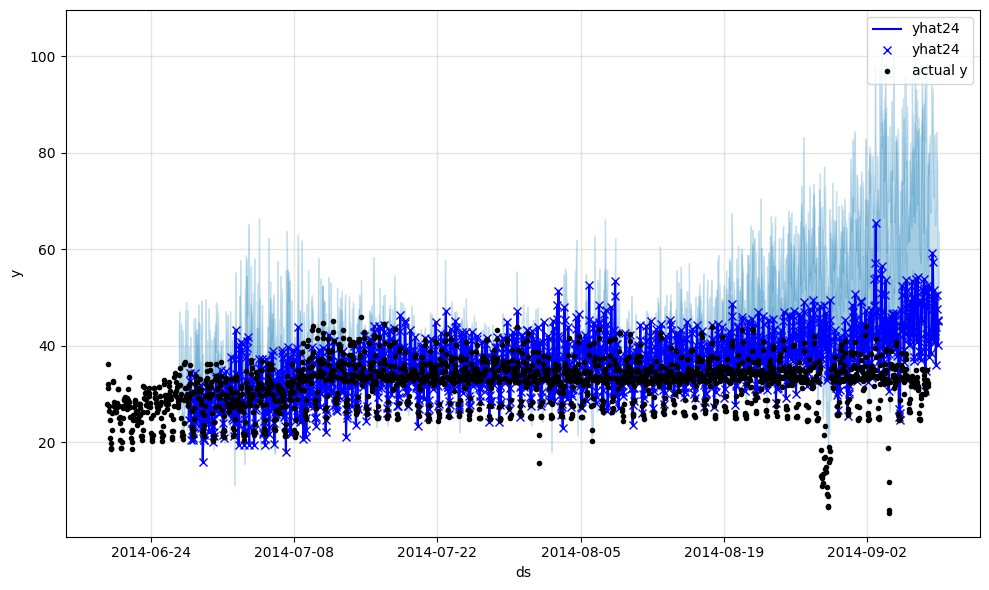

In [71]:
fig = m.plot(forecast[forecast["ID"] == "MT_002"])

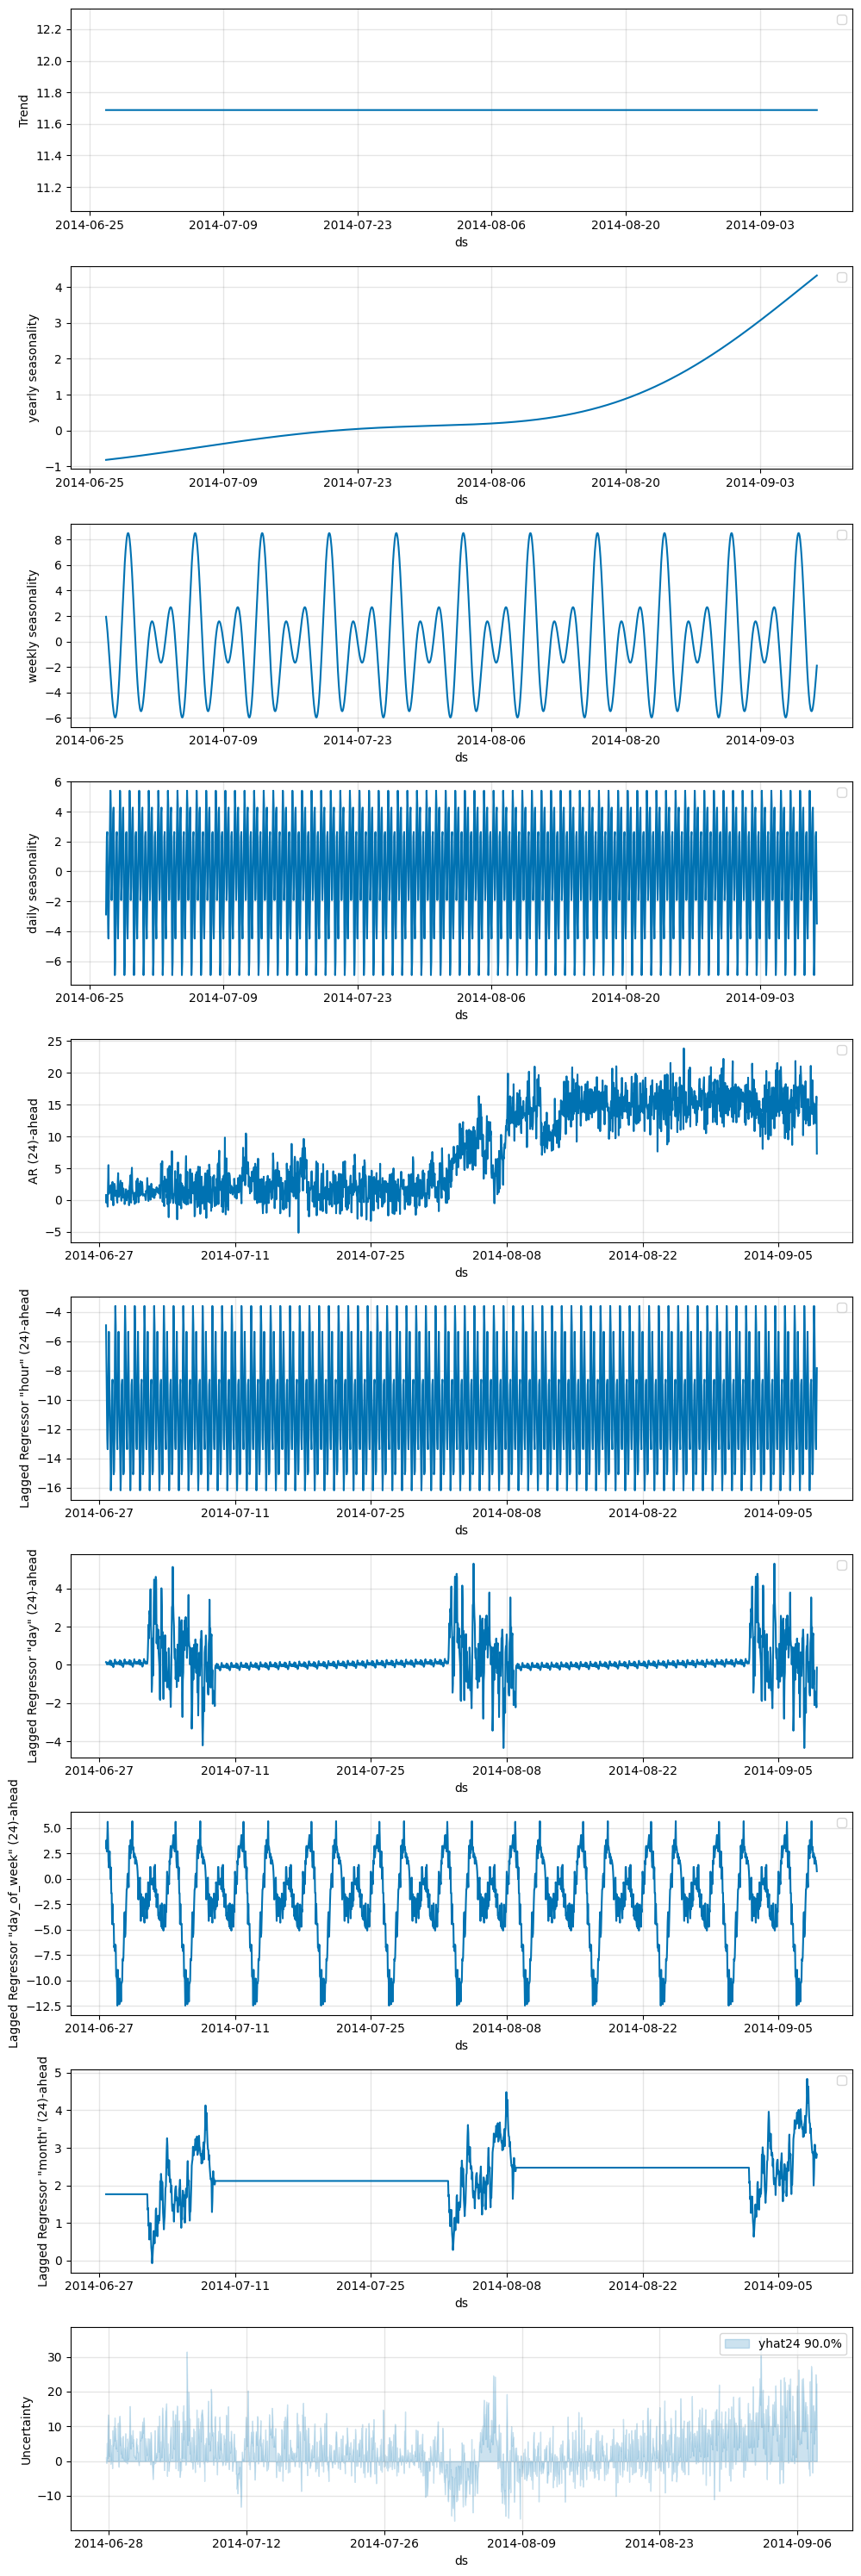

In [65]:
fig = m.plot_components(forecast[forecast["ID"] == 'MT_001'])

#fig = m.plot_components(forecast[-8 * 24 :])   #print only for last 7 days

In [ ]:
# code for whole arima training
# load data
train_data, test_data, val_data = electricity_dataloader.create_electricity_timeseries_np()

predictions_path = CONFIG_DICT["models"]["electricity"] / "arima" / "global_preds_arima.csv"

try:
    global_preds_arima = pd.read_csv(predictions_path) 
except:
    print("No predictions available.")
    global_preds_arima = pd.DataFrame(columns=["id_nr", "forecasts", "test_data_id_predict_y", "global_confidence_upper", "global_confidence_lower"])

    
# iterate over all ids
for id_string in test_data.categorical_id.unique():
    start_time = time.time()
    
    # skip over ids that have predictions present, id=15 throws "LinAlgError: LU decomposition error."
    if int(id_string) in global_preds_arima["id_nr"].values or id_string=="15":
        continue
        
    # select one id, define x/y train dataframe and fit model
    train_data_id = train_data[train_data["categorical_id"] == id_string]
    train_data_id = train_data_id[int(len(train_data_id) * 0.8) :]
    train_data_id_y = train_data_id["power_usage"]
    train_data_id_x = train_data[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()

    model = Arima.auto_arima(train_data_id_y, exogenous=train_data_id_x, stepwise=True, seasonal=True, m=24, maxiter=5)


    # refit model on test_data and predict on last 24 timesteps
    test_data_id = test_data[test_data["categorical_id"] == id_string]
    train_limit = (len(test_data_id)) - 24
    test_data_id_update, test_data_id_predict = train_test_split(test_data_id, train_size=train_limit)

    test_data_id_update_y = test_data_id_update["power_usage"]
    test_data_id_predict_y = test_data_id_predict["power_usage"]

    test_data_id_update_x = test_data_id_update[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()
    test_data_id_predict_x = test_data_id_predict[["categorical_hour", "time_idx", "categorical_day_of_week"]].copy()

    model.update(test_data_id_update_y, test_data_id_update_x)

    # make your forecasts
    forecasts, confidence = model.predict(test_data_id_predict_y.shape[0], return_conf_int=True, exogenous=test_data_id_predict_x, alpha=0.1)
    
    end_time = time.time()
    print(f"Mean absolute error for id {id_string} is: {(mean_absolute_error(test_data_id_predict_y, forecasts)):.3f}. This iteration took: {((end_time-start_time)/60):.2f} minutes.")

    id_list = [id_string] * 24
    
    # join relevent values to dataframe
    output = pd.DataFrame({
                        'id_nr': id_list,
                        'forecasts': forecasts,
                        'test_data_id_predict_y': test_data_id_predict_y,
                        'global_confidence_upper': confidence[:,1],
                        'global_confidence_lower': confidence[:,0]
                        })
    
    # join to present predictions
    global_preds_arima = pd.concat([global_preds_arima, output], axis=0)

    global_preds_arima.to_csv(predictions_path, index=False)
        
print(f"Mean absolute error: {mean_absolute_error(global_preds_arima.forecasts , global_preds_arima.test_data_id_predict_y)}")